# Principle Component analysis of crowdfunding projects
Data visualization of Kickstarter projects based on suitable visualization techniques including a principal component analysis (PCA).

The dataset was downloaded from
https://www.kaggle.com/kemical/kickstarter-projects 
on September 14th 2018.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
import plotly as py
import plotly.graph_objs as go
import seaborn as sns

# use plotly in offline mode:
py.offline.init_notebook_mode(connected=True)

In [2]:
%matplotlib inline

In [3]:
# basic pandas settings
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

## 1. Data inspection and cleaning

In [4]:
# create the dataframe and define a reduced version with the first 
# 5000 observations of project goal and the total amount pledged
raw_data = pd.read_csv('ks-projects-201801.csv')
cols = ['goal', 'pledged']
df = pd.DataFrame(raw_data, columns = cols)
df_training = df[0:5000] # real training set: df[0:250000]
# df_testing = df[250000:]

# compute (reduced) dataframe dimensions (X = N x M)
N = len(df['goal'])
M = len(cols)

In [5]:
# Initial check for missing values
col = raw_data.columns

for i in col:
    if raw_data[i].isnull().sum().sum() != 0:
        print(i)
        print(raw_data[i].isnull().sum().sum())

# 4 missing name values
# 3797 missing usd pledged values
# We won't be using either of these attributes
# so let's not worry about this.

name
4
usd pledged
3797


In [6]:
# Now for the categories. Let's view them:
cat = raw_data.loc[:,'category']

if cat.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    cat_sort = sorted(set(cat))
    print(cat_sort)
    print('\nTotal number of individual categories: \n', len(cat_sort))

---- No empty strings/None values detected ----
['3D Printing', 'Academic', 'Accessories', 'Action', 'Animals', 'Animation', 'Anthologies', 'Apparel', 'Apps', 'Architecture', 'Art', 'Art Books', 'Audio', 'Bacon', 'Blues', 'Calendars', 'Camera Equipment', 'Candles', 'Ceramics', "Children's Books", 'Childrenswear', 'Chiptune', 'Civic Design', 'Classical Music', 'Comedy', 'Comic Books', 'Comics', 'Community Gardens', 'Conceptual Art', 'Cookbooks', 'Country & Folk', 'Couture', 'Crafts', 'Crochet', 'DIY', 'DIY Electronics', 'Dance', 'Design', 'Digital Art', 'Documentary', 'Drama', 'Drinks', 'Electronic Music', 'Embroidery', 'Events', 'Experimental', 'Fabrication Tools', 'Faith', 'Family', 'Fantasy', "Farmer's Markets", 'Farms', 'Fashion', 'Festivals', 'Fiction', 'Film & Video', 'Fine Art', 'Flight', 'Food', 'Food Trucks', 'Footwear', 'Gadgets', 'Games', 'Gaming Hardware', 'Glass', 'Graphic Design', 'Graphic Novels', 'Hardware', 'Hip-Hop', 'Horror', 'Illustration', 'Immersive', 'Indie Rock',

In [7]:
# We inspect the cat_sort vector and don't
# find any mistakes/errors.

# We'll use 1-of-K encoding. Declare the attribute
# categorical with pandas
raw_data['category'] = pd.Categorical(raw_data['category'])

# 1-of-K and combine w/ raw data
cat_Dummies = pd.get_dummies(raw_data['category'], prefix = 'category')
raw_data = pd.concat([raw_data, cat_Dummies], axis=1)

# Check columns
raw_data.columns.values

array(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real',
       'category_3D Printing', 'category_Academic',
       'category_Accessories', 'category_Action', 'category_Animals',
       'category_Animation', 'category_Anthologies', 'category_Apparel',
       'category_Apps', 'category_Architecture', 'category_Art',
       'category_Art Books', 'category_Audio', 'category_Bacon',
       'category_Blues', 'category_Calendars',
       'category_Camera Equipment', 'category_Candles',
       'category_Ceramics', "category_Children's Books",
       'category_Childrenswear', 'category_Chiptune',
       'category_Civic Design', 'category_Classical Music',
       'category_Comedy', 'category_Comic Books', 'category_Comics',
       'category_Community Gardens', 'category_Conceptual Art',
       'category_Cookbooks', 'category_Country & Folk',
       'ca

In [8]:
# Now for the main categories. Let's view them:
main_cat = raw_data.loc[:,'main_category']
if main_cat.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    main_cat_sort = sorted(set(main_cat))
    print(main_cat_sort)

---- No empty strings/None values detected ----
['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'Theater']


In [9]:
# No mistakes/errors. 1-of-K encoding. Declare categorical
raw_data['main_category'] = pd.Categorical(raw_data['main_category'])

# 1-of-K and combine w/ raw data
main_cat_Dummies = pd.get_dummies(raw_data['main_category'], prefix = 'main_cat')
raw_data = pd.concat([raw_data, main_cat_Dummies], axis=1)

# Check columns
raw_data.columns.values

array(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real',
       'category_3D Printing', 'category_Academic',
       'category_Accessories', 'category_Action', 'category_Animals',
       'category_Animation', 'category_Anthologies', 'category_Apparel',
       'category_Apps', 'category_Architecture', 'category_Art',
       'category_Art Books', 'category_Audio', 'category_Bacon',
       'category_Blues', 'category_Calendars',
       'category_Camera Equipment', 'category_Candles',
       'category_Ceramics', "category_Children's Books",
       'category_Childrenswear', 'category_Chiptune',
       'category_Civic Design', 'category_Classical Music',
       'category_Comedy', 'category_Comic Books', 'category_Comics',
       'category_Community Gardens', 'category_Conceptual Art',
       'category_Cookbooks', 'category_Country & Folk',
       'ca

In [10]:
# Now for currencies. Let's view them:
cur = raw_data.loc[:,'currency']
if cur.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    cur_sort = sorted(set(cur))
    print(cur_sort)

---- No empty strings/None values detected ----
['AUD', 'CAD', 'CHF', 'DKK', 'EUR', 'GBP', 'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK', 'SGD', 'USD']


In [11]:
# No mistakes/errors. Declare categorical
raw_data['currency'] = pd.Categorical(raw_data['currency'])

# 1-of-K and combine w/ raw data
cur_Dummies = pd.get_dummies(raw_data['currency'], prefix = 'currency')
raw_data = pd.concat([raw_data, cur_Dummies], axis=1)

# Check columns
raw_data.columns.values

array(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real',
       'category_3D Printing', 'category_Academic',
       'category_Accessories', 'category_Action', 'category_Animals',
       'category_Animation', 'category_Anthologies', 'category_Apparel',
       'category_Apps', 'category_Architecture', 'category_Art',
       'category_Art Books', 'category_Audio', 'category_Bacon',
       'category_Blues', 'category_Calendars',
       'category_Camera Equipment', 'category_Candles',
       'category_Ceramics', "category_Children's Books",
       'category_Childrenswear', 'category_Chiptune',
       'category_Civic Design', 'category_Classical Music',
       'category_Comedy', 'category_Comic Books', 'category_Comics',
       'category_Community Gardens', 'category_Conceptual Art',
       'category_Cookbooks', 'category_Country & Folk',
       'ca

In [12]:
# As far as the dates go, we'd like to exclude projects that started
# before April of 2009 and projects that ended after September of 2018
# (we only want to look at finished projects)

raw_data['launched'] = pd.to_datetime(raw_data['launched'])
raw_data['deadline'] = pd.to_datetime(raw_data['deadline'])
print(len(raw_data[raw_data['launched'] < pd.Timestamp('2009-04-28')]), \
     'projects with implausible starting date were found and removed.')

# There are 12 observations that started before Kickstarter's founding.
# These are removed and checked:
raw_data = raw_data[raw_data['launched'] >= pd.Timestamp('2009-04-28')]
len(raw_data[raw_data['launched'] < pd.Timestamp('2009-04-28')]) == 0

12 projects with implausible starting date were found and removed.


True

In [13]:
# Check dates for missing values
if raw_data.launched.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    
if raw_data.deadline.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

---- No empty strings/None values detected ----
---- No empty strings/None values detected ----


In [14]:
# Now we'd like to go from "launched" and "deadline"
# to "duration" (in days), "yearlaunched", "monthlaunched"
# and the number of the month after the founding of Kickstarter

# Year launched 
raw_data['yearlaunched'] = pd.DatetimeIndex(raw_data['launched']).year
# Month launched 
raw_data['monthlaunched'] = pd.DatetimeIndex(raw_data['launched']).month

# Make a new coloum with the new duration
raw_data['duration']=(raw_data['deadline']-raw_data['launched']).astype('timedelta64[h]')/24

In [15]:
# Kickstarter was founded in April 2009. We'll assign this April 
# to the value zero and count up 1 for every month after that
# (e.g. June 2010 = 13)
year_month = raw_data[['yearlaunched', 'monthlaunched']]

# (-5) at the end to make May the first month
month_absolute = (year_month.iloc[:, 0] - 2009) * 12 + (year_month.iloc[:, 1] - 5)

# add to dataframe
raw_data['month_absolute'] = month_absolute
raw_data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state',
       ...
       'currency_MXN', 'currency_NOK', 'currency_NZD', 'currency_SEK',
       'currency_SGD', 'currency_USD', 'yearlaunched', 'monthlaunched',
       'duration', 'month_absolute'],
      dtype='object', length=207)

In [16]:
# Let's 1-of-K the yearlaunched attribute
# Check for missing values
if raw_data.yearlaunched.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    yr = raw_data.yearlaunched
    print('---- No empty strings/None values detected ----')
    yr_sort = sorted(set(yr))
    print(yr_sort)

---- No empty strings/None values detected ----
[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [17]:
# No mistakes/errors. Declare categorical
raw_data['yearlaunched'] = pd.Categorical(raw_data['yearlaunched'])

# 1-of-K and combine w/ raw data
yr_Dummies = pd.get_dummies(raw_data['yearlaunched'], prefix = 'yearlaunched')
raw_data = pd.concat([raw_data, yr_Dummies], axis=1)

In [18]:
# Kickstarter projects used to have a max duration of 90 days (now 60 days).
# Therefore we'd like to cut the projects that have a duration of over 90 days.
print(len(raw_data[raw_data['duration'] > 90]), \
     'projects with implausible project duration were found and removed.')

# There are 457 such projects. Cut and check:
raw_data = raw_data[raw_data['duration'] < 90]
len(raw_data[raw_data['duration'] > 90]) == 0

457 projects with implausible project duration were found and removed.


True

In [19]:
# Now for the states. Let's view them:
states = raw_data['state']
if states.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    states_sort = sorted(set(states))
    print(states_sort)

# We inspect the states_sort vector and don't
# find any mistakes/errors. We do, however, have canceled, failed, suspended,
# undefined, and live projects.

---- No empty strings/None values detected ----
['canceled', 'failed', 'live', 'successful', 'suspended', 'undefined']


In [20]:
# Let's start by inspecting at the undefined.
undefined = raw_data[states == 'undefined']
print(undefined)

                ID                                               name  \
169     1000694855                      STREETFIGHTERZ WHEELIE MURICA   
328      100149523                        Duncan Woods - Chameleon EP   
632     1003023003          The Making of Ashley Kelley's Debut Album   
647     1003130892                       Butter Side Down Debut Album   
749     1003629045                            Chase Goehring debut EP   
...            ...                                                ...   
378233   997971307  EQUUS International Film Festival®, all-equine...   
378303   998319149                            Emily 2050 - Short Film   
378434     9988744                             Matthew Stephens Music   
378585   999610349     Lady Vendredi: Afrofuturist concept 12 inch EP   
378588   999621278                     Jeune auteur a besoin de vous!   

            category main_category currency   deadline     goal  \
169     Film & Video  Film & Video      USD 2014-09-20 6

In [21]:
# Seems like most of the undefined are in main categories "Music",
# "Publishing" or "Film & Video":
percent_undefined = (len(undefined[undefined['main_category'] == 'Music'])+ \
       len(undefined[undefined['main_category'] == 'Publishing'])+ \
       len(undefined[undefined['main_category'] == 'Film & Video']))/len(undefined)

print('%.1f' % float(percent_undefined*100), \
      'percent of undefined projects were in categories "Music", "Publishing" or "Film & Video".',\
     '\nAll undefined projects were removed.')

# Based on what we're doing, we can't really use undefined 
# projects for anything, so we'll take these rows out.
raw_data = raw_data[raw_data['state'] != 'undefined']
len(raw_data[raw_data['state'] == 'undefined']) == 0

99.7 percent of undefined projects were in categories "Music", "Publishing" or "Film & Video". 
All undefined projects were removed.


True

In [22]:
# Let's inspect the paused projects.
print(len(raw_data[states == 'suspended']), \
      'paused projects were removed from the dataset.')

# There are about 1800 of these. We'll take them out as well, since they don't
# help us.
raw_data = raw_data[raw_data['state'] != 'suspended']
len(raw_data[raw_data['state'] == 'suspended']) == 0

C:\Users\User\AppData\Local\Programs\Python\Python36\Lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



1845 paused projects were removed from the dataset.


True

In [26]:
# Now for canceled projects:
print(len(raw_data[states == 'canceled']), 'projects with status "canceled".')

# About 10% of projects in the data set have been canceled. Let's keep these
# in and see if the algorithm can guess which projects will be canceled.

38751 projects with status "canceled".


C:\Users\User\AppData\Local\Programs\Python\Python36\Lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [27]:
# Now for live projects:
len(raw_data[states == 'live'])

# There are about 2800 of these. The data was pulled in January 2018, so
# let's see what that means in terms of end dates.
live = raw_data[raw_data['state'] == 'live'].sort_values(by = 'deadline')
live

C:\Users\User\AppData\Local\Programs\Python\Python36\Lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,yearlaunched_2009,yearlaunched_2010,yearlaunched_2011,yearlaunched_2012,yearlaunched_2013,yearlaunched_2014,yearlaunched_2015,yearlaunched_2016,yearlaunched_2017,yearlaunched_2018
371277,961951460,Jahque Inc. is merging with Reesi's Cakes 'N T...,Events,Food,USD,2016-05-05,"25,000.00",2016-04-05 06:01:09,0.00,live,...,0,0,0,0,0,0,0,1,0,0
339521,79946509,Omnicharge: Smart & Compact Portable Power Bank,Gadgets,Technology,USD,2016-08-08,"8,000.00",2016-07-25 23:57:23,"7,035.00",live,...,0,0,0,0,0,0,0,1,0,0
304386,619709625,Escapsim,Film & Video,Film & Video,USD,2017-02-16,"5,000.00",2017-01-07 21:54:19,30.00,live,...,0,0,0,0,0,0,0,0,1,0
19716,1100111323,DAWSON HOLLOW,Indie Rock,Music,USD,2017-04-20,"40,000.00",2017-03-17 18:06:01,20.00,live,...,0,0,0,0,0,0,0,0,1,0
229599,237278551,Flyboard Air®,Technology,Technology,EUR,2017-08-15,"250,000.00",2017-07-16 14:56:18,520.00,live,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260693,396064457,Deaths of Athazar,Games,Games,USD,2018-03-02,"15,000.00",2018-01-01 13:27:13,1.00,live,...,0,0,0,0,0,0,0,0,0,1
292034,55596200,Plateforme de statistiques,Apps,Technology,EUR,2018-03-02,"9,000.00",2018-01-01 15:40:26,0.00,live,...,0,0,0,0,0,0,0,0,0,1
226982,22387366,Nerd Collect,Apps,Technology,GBP,2018-03-03,"150,000.00",2018-01-02 03:26:52,0.00,live,...,0,0,0,0,0,0,0,0,0,1
7164,1036415983,Aikyam : Onnu,Music,Music,USD,2018-03-03,"10,000.00",2018-01-02 08:11:58,174.00,live,...,0,0,0,0,0,0,0,0,0,1


In [28]:
# The first 7 examples are mistakes of some sort. Let's see what's up:
live.iloc[0:7,:]['usd_pledged_real'] - live.iloc[0:7,:]['usd_goal_real']

371277    -25,000.00
339521       -965.00
304386     -4,970.00
19716     -39,980.00
229599   -292,889.09
44312      -2,680.00
178739    -33,394.33
dtype: float64

In [29]:
# Its seems that all these projects actually failed. Let's change their status.
# Copy slice
notlive = raw_data['state'][raw_data['deadline'] < pd.Timestamp('2018-01-01')][raw_data['state'] == 'live'].copy()

# Edit copy
for i in range(len(notlive)):
    notlive.iloc[i] = 'failed'

In [30]:
# Update original dataframe and check
raw_data.update(notlive)
len(raw_data['state'][raw_data['deadline'] < pd.Timestamp('2018-01-01')][raw_data['state'] == 'live']) == 0

# Delete rest of the live values and check
raw_data = raw_data[raw_data['state'] != 'live']
len(raw_data[raw_data['state'] == 'live']) == 0

True

In [31]:
# Let's view states again
states_1 = raw_data.loc[:,'state']
if states_1.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    states_1_sort = sorted(set(states_1))
    print(states_1_sort)

---- No empty strings/None values detected ----
['canceled', 'failed', 'successful']


In [32]:
# No mistakes/errors. Declare categorical
raw_data['state'] = pd.Categorical(raw_data['state'])

# 1-of-K and combine w/ raw data
state_Dummies = pd.get_dummies(raw_data['state'], prefix = 'state')
raw_data = pd.concat([raw_data, state_Dummies], axis=1)

In [33]:
# Let's look at backers. Check for missing values
if raw_data.backers.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

---- No empty strings/None values detected ----


In [34]:
# Now for the countries. Let's view them:
if raw_data.country.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    countries = raw_data.country
    print('---- No empty strings/None values detected ----')
    countries_sort = sorted(set(countries))
    print(countries_sort)

---- No empty strings/None values detected ----
['AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'N,0"', 'NL', 'NO', 'NZ', 'SE', 'SG', 'US']


In [35]:
# 'N,0"' is clearly a mistake.
raw_data.country[raw_data.country == 'N,0"']

2457      N,0"
4338      N,0"
4892      N,0"
5353      N,0"
5597      N,0"
          ... 
371277    N,0"
371387    N,0"
372375    N,0"
375359    N,0"
378188    N,0"
Name: country, Length: 233, dtype: object

In [36]:
# For whatever reason there are 233 of these observations. No clue what that
# means. Let's check currency for these observations
raw_data.currency[raw_data.country == 'N,0"']

2457      USD
4338      USD
4892      USD
5353      USD
5597      USD
         ... 
371277    USD
371387    EUR
372375    USD
375359    USD
378188    USD
Name: currency, Length: 233, dtype: category
Categories (14, object): [AUD, CAD, CHF, DKK, ..., NZD, SEK, SGD, USD]

In [37]:
# All sorts of different currencies. Let's check more generally.
raw_data[raw_data.country == 'N,0"'].sort_values(by = 'usd_pledged_real')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,yearlaunched_2012,yearlaunched_2013,yearlaunched_2014,yearlaunched_2015,yearlaunched_2016,yearlaunched_2017,yearlaunched_2018,state_canceled,state_failed,state_successful
289718,544130636,Anabella and The Lost Kingdom-- short film,Film & Video,Film & Video,USD,2016-05-27,"4,500.00",2016-05-02 21:02:32,0.00,canceled,...,0,0,0,0,1,0,0,1,0,0
74887,1381563978,Butterfield VHS Tape Recovery Project,Film & Video,Film & Video,USD,2016-05-29,"1,200.00",2016-04-29 22:34:34,0.00,canceled,...,0,0,0,0,1,0,0,1,0,0
291121,551357943,XHuman,Music,Music,USD,2016-05-27,"5,000.00",2016-03-28 16:24:08,0.00,failed,...,0,0,0,0,1,0,0,0,1,0
42065,121413755,have you seen jordan?,Music,Music,USD,2016-06-22,"3,200.00",2016-04-23 06:19:25,0.00,canceled,...,0,0,0,0,1,0,0,1,0,0
44594,1226622252,Documentary: A Child Of Their Own,Film & Video,Film & Video,USD,2016-05-13,"15,000.00",2016-04-28 11:28:39,0.00,canceled,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368860,949209229,Be A Catalyst!!!! Help Casey Clark make a name...,Music,Music,USD,2016-05-24,"8,000.00",2016-03-25 03:54:04,"9,625.00",successful,...,0,0,0,0,1,0,0,0,0,1
170332,1866608144,"ensemble, et al. second full-length album —wit...",Music,Music,USD,2016-04-26,"8,000.00",2016-03-26 18:56:44,"9,897.00",successful,...,0,0,0,0,1,0,0,0,0,1
264759,416754357,Stixx garland clamp: easiest way to hang up pa...,Product Design,Design,EUR,2016-05-01,"10,000.00",2016-04-01 09:07:12,"10,063.00",successful,...,0,0,0,0,1,0,0,0,0,1
47931,1244340555,Stern Pinball Arcade: AC/DC,Video Games,Games,USD,2016-06-01,"108,435.00",2016-05-02 20:22:39,"17,425.00",canceled,...,0,0,0,0,1,0,0,1,0,0


In [38]:
# Let's not delete these values. At least one of these projects seem significant
# (there's one with over 2.7 mio USD pledged).

# 1-of-K encoding. Declare categorical
raw_data.country = pd.Categorical(raw_data.country)

# 1-of-K and combine w/ raw data
country_Dummies = pd.get_dummies(raw_data.country, prefix = 'country')
raw_data = pd.concat([raw_data, country_Dummies], axis=1)

In [39]:
# We only want to use usd_pledged_real and usd_goal_real, so we'll delete
# everything else. Now we'll also delete the ID and name columns, and the
# categorical variables that we've 1-of-K encoded.

# First let's check usd_pledged_real and usd_goal_real. Check for missing values:
pledged = raw_data.usd_pledged_real
if pledged.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    
goal = raw_data.usd_goal_real
if goal.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

---- No empty strings/None values detected ----
---- No empty strings/None values detected ----


In [40]:
# Check for negatives:
len(raw_data[raw_data['usd_pledged_real'] < 0])
len(raw_data[raw_data['usd_goal_real'] < 0])

0

In [42]:
# Now let's take the important part of the data
backers_data = raw_data.backers
cleaned_data = pd.concat([backers_data, raw_data.iloc[:,13:]], axis=1)
cleaned_data = cleaned_data.drop(['yearlaunched'], axis = 1)
cleaned_data.columns.values

# Check one last time for missing data
print('No more missing data in the dataset.')
cleaned_data.isnull().sum().sum() == 0

# ----------- OUTPUT FOR ALL OF THIS IS THE DATAFRAME cleaned_data -------
# ----------- FOR PCA, RATIO ATTRIBUTES STILL NEED TO BE NORMALIZED ------
# ----------- FOR PLOTS, OUTLIERS NEED TO BE TAKEN OUT -------------------

No more missing data in the dataset.


True

In [43]:
np.shape(cleaned_data)

(369961, 230)

**Bottom line data preprocessing**   
***
The various preprocessing steps have changed the dimensions of the dataset. The data matrix has lost some observations in the cleaning process but gained a lot of attributes, mainly due to 1 of K encoding.  
  
The current shape and size of __X__ (called `cleaned_data`) is displayed in the two cells above. In total, we're left with  
**N** = 229 attributes of  
**M** = 372758 features  
(adding up to over 85 million entries).

## 2. Visualizations



On average, projects in this dataset were launched 5.22 years after Kickstarter was founded.


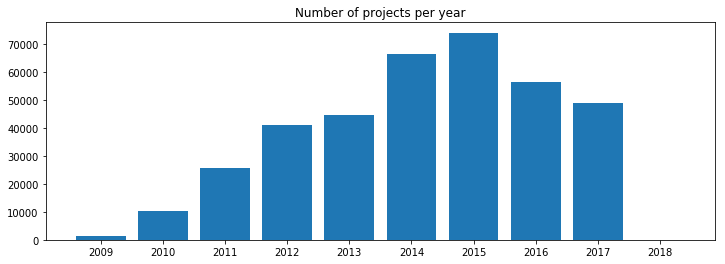

In [47]:
# In which year did projects start?

# create a list of indices to address the individual years
yearlaunched_index_ = list('yearlaunched_' + str(yr_sort[i]) for i in range(len(yr_sort)))

# sum up number of projects per year and store in list
projects_per_year = list(cleaned_data[yearlaunched_index_[year]].sum() for year in range(len(yr_sort)))

# calculate mean launchyear relative to Kickstarter founding.
years_after_launch = np.arange(10)
mean_launchyear = sum(projects_per_year*years_after_launch)/sum(projects_per_year)
print('On average, projects in this dataset were launched', \
      '%.2f' % mean_launchyear, 'years after Kickstarter was founded.')

fig, ax = plt.subplots(figsize=(12,4))
ax.bar(yr_sort, projects_per_year)
ax.set(title='Number of projects per year', xticks=yr_sort);

In [51]:
cleaned_data['month_absolute']

0          75
1         100
2          44
3          34
4          74
         ... 
378656     64
378657     25
378658     14
378659     80
378660     26
Name: month_absolute, Length: 369961, dtype: int64

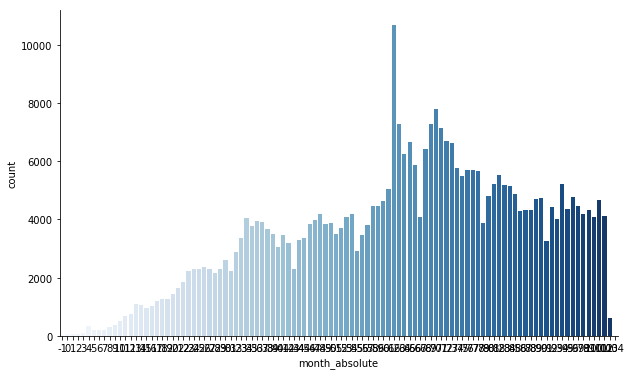

In [55]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(
    cleaned_data['month_absolute'],
    palette='Blues'
)
sns.despine()

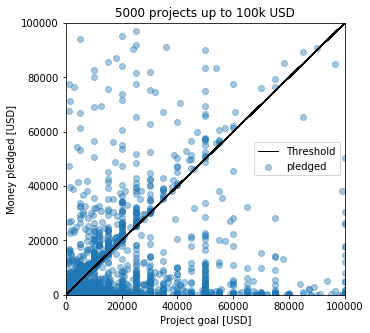

In [45]:
# plot a simple relationship
fig, ax = plt.subplots(figsize=(5,5))
ax.set(title='5000 projects up to 100k USD',
      xlabel='Project goal [USD]', ylabel='Money pledged [USD]',
      xlim=[0, 100000], ylim=[0, 100000])
ax.scatter(df_training['goal'], df_training['pledged'], alpha=0.4)
ax.plot(df_training['goal'], df_training['goal'], color='black', linewidth=1, label='Threshold')
ax.legend()
# idea: split dataset
success_mask = [df_training['pledged'] >= df_training['goal']]
# 'succeeded'-color blue, else 'failed'-red 

## 3. Principle component analysis

Next up is decomposing this set into its principal components. The mean value of all interval or ratio data is computed and stored as pandas object `means`, thre respective standard deviations are calculated using numpy's `std()`. 

The data is then normalized to prepare it for the singular value decomposition. As attribute values differ by orders of magnitude, they are all divided by their standard deviation (eg. compare number of backers: ~$10^2$ to funding goals: ~$10^4$).

In [82]:
# Extract all ratio columns for normalization and calculate mean.

ratio_data = ['backers', 'usd_pledged_real', 'usd_goal_real', 'duration', 'month_absolute']

means = round(cleaned_data[ratio_data].mean())
print('Mean values of ratio attributes:\n')
print(means)

standard_deviations = round(np.std(cleaned_data[ratio_data]))
print('\nTheir standard deviations:\n')
print(standard_deviations)                            

Mean values of ratio attributes:

backers               107.00
usd_pledged_real    9,156.00
usd_goal_real      45,084.00
duration               34.00
month_absolute         64.00
dtype: float64

Their standard deviations:

backers                  916.00
usd_pledged_real      91,724.00
usd_goal_real      1,128,930.00
duration                  13.00
month_absolute            23.00
dtype: float64


In [84]:
# Subtract mean value from data and divide by standard deviation
normalized = (cleaned_data[ratio_data] - means)/standard_deviations

# PCA by computing SVD of Y
U,S,V = svd(normalized,full_matrices=False)
# print('U[0] = ', U[0], '\nS[0] =', S[0], '\nV[0] =', V[0])

# Compute variance explained by principal components
rho = (S**2) / (S**2).sum()

print('The first four principal components explain', '%.1f' % sum(rho[i]*100 for i in range(4)),'% of the variance.')

The first four principal components explain 95.0 % of the variance.


In [85]:
# Plot variance explained

# I've decided to implement the graphs in plotly because the
# interactiveness can become really helpful with more complex plots later on

layout = go.Layout(xaxis=dict(title='Principal component', dtick=1), 
                   yaxis=dict(title='Variance explained'),
                   )

trace1 = go.Scatter(
    name = 'VE absolute',
    x = np.arange(1,len(rho)+1),
    y = rho )
trace2 = go.Scatter(
    name = 'VE cumulated',
    x = np.arange(1,len(rho)+1),
    y = np.cumsum(rho) )


data = [trace1, trace2]

fig = go.Figure(data=[trace1, trace2], layout=layout)
py.offline.iplot(fig)

In [ ]:
# should you prefer matplotlib, this block gives the same output:

# fig, ax = plt.subplots(figsize=(4,4))
# ax.plot(range(1,len(rho)+1),rho,'o-')
# ax.set(title='Variance explained by principal components', 
#         xlabel='Principal component', ylabel='Variance explained', 
#        xticks=[1,2,3,4])

In [ ]:
# for plotting purposes, a reduced dataframe
interval_ratio = cleaned_data[interval_or_ratio]
interval_ratio_reduced = interval_ratio[0:100]
print(interval_ratio_reduced['backers'])

In [ ]:
V = V.T
# Project the centered data onto principal component space
Z = np.array(normalized @ V)


# Indices of the principal components to be plotted
pc1 = 0
pc2 = 1
pc3 = 2

component1 = Z[interval_ratio_reduced['backers'],pc1]
component2 = Z[interval_ratio_reduced['duration'],pc2]

# Plot PCA of the data
f = plt.figure()
plt.title('Kickstarter data: PCA')
for c in range(len(interval_ratio_reduced['backers'])):
    plt.plot(component1[c], 
             component2[c], 'o')

In [ ]:
# plot first 3 principle components in 3d
# so far, x, y and z are just for testing purposees

scatter = dict(
    mode = "markers",
    name = "y",
    type = "scatter3d",    
    x = [1,2,3], y = [2,3,4], z = [3,4,5],
    marker = dict( size=2, color="rgb(23, 190, 207)" ))

layout = dict(
    title = '3d point clustering',
    scene = dict(
        xaxis = dict( zeroline=False ),
        yaxis = dict( zeroline=False ),
        zaxis = dict( zeroline=False ) ))
    
fig2 = dict(data=[scatter], layout=layout)
py.offline.iplot(fig2)